<h2>Introduction </h2>
This project takes a dataset from UCI's Machine Learning Database which describes various feautures of a car as well as the percieved Value of each car. My goal for this project is to use a random forest classifier to determine if a car should be classified as "unacceptable", "acceptable", "good" or "very good" in terms of value.

One of the advantages of the Random Forest method I am taking advantage of is the lack of requirements for the data I train ther model with. This is different from other models I have worked with because they require the data to fit some set of requirements.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("[+] Complete")

[+] Complete


In [2]:
col = ["buying","maint","doors","persons","lug_boot","safety","value"]

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',names = col)


In [3]:
print(df.dtypes)
print()
print(df.head(2))

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
value       object
dtype: object

  buying  maint doors persons lug_boot safety  value
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc


We have succesfully imported the data, now we will clean it up and make the values for most features categorical. since the categorical varaibles are ordinal, it is appropriate to assign increasing numerical values to represent these values.

The data itself is not particularily complex, which each feature having somme categoricial variable relating to the feature, making the dataset a great candidate for a random forest classification.

In [4]:
for i in df:
    print(i,set(df[i]))

buying {'med', 'vhigh', 'low', 'high'}
maint {'med', 'vhigh', 'low', 'high'}
doors {'5more', '3', '2', '4'}
persons {'more', '2', '4'}
lug_boot {'med', 'big', 'small'}
safety {'med', 'high', 'low'}
value {'good', 'acc', 'unacc', 'vgood'}


In [5]:
cleanup = {"buying":{"low":1,"med":2,"high":3,"vhigh":4},
           "maint" :{"low":1,"med":2,"high":3,"vhigh":4},
           "doors":{"2":2,"3":3,"4":4,"5more":5},
           "persons":{"2":2,"4":4,"more":5},
           "lug_boot":{"small":1,"med":2,"big":3},
           "safety":{'high':3, 'low':1, 'med':2},
           "value": {'good':3, 'unacc':1, 'acc':2, 'vgood':4}
    
}
df.replace(cleanup, inplace=True)
df.head()

,buying,maint,doors,persons,lug_boot,safety,value
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


Now that our data is cleaned up, I will split up the data into a group to test the model and then a group to train our model.

For the random forest, I am leaving most of the parameters as default since there is nothing that leads me to believe the data is not compatable with the model.

In [20]:
from sklearn.model_selection import train_test_split
X = df.drop(["value"],axis=1)
y = df['value']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [24]:
import sklearn.ensemble
clf =sklearn.ensemble.RandomForestClassifier(100)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

Now, to evaluate the model we can look at thje confusion matrix for this classification.

In [27]:
import sklearn.metrics
CM =sklearn.metrics.confusion_matrix(y_test, y_pred)

CM, random_state=42)

array([[393,   4,   0,   0],
       [  4, 115,   9,   1],
       [  0,   0,  19,   1],
       [  0,   3,   0,  22]], dtype=int64)

We can canculate the accuracy of the model by calculating the correct classifications over the total classifications


In [48]:
correct = CM[0][0] + CM[1][1] +  CM[2][2] + CM[3][3]
total = len(y_test)
print("Number Correct: "+str(correct),"Number Total: "+ str(total),"Accuracy: " + str(correct/total*100),sep="\n")

Number Correct: 549
Number Total: 571
Accuracy: 96.14711033274956


Although a accuracy rate of 96.14% might as first seem excellent, it is important to rememmber the number in the context of the classification. This classifier attempts to predict the value for a car, so too high of a value might be bad for buyers, and too low of a vlaue might be bad for sellers.

In the context of this confusion matrix, the rows indicate the actual classification, and the columns are how our model classified the data.

In [50]:
under,over = 0,0

for i in range(len(CM)):
    for j in range(len(CM[i])):
        if j>i:
            over+=CM[i][j]
        if j<i:
            under += CM[i][j]
print("Number Over: " + str(over),"Number Under: " + str(under),"Percent of total error Over: " + str(over/(over+under)*100),sep="\n")


Number Over: 15
Number Under: 7
Percent of total error Over: 68.18181818181817


Out of all of the errors, the model tends to overpredict value about twice as often as it underpredicts value.

Here is a bar chart of how this breaks down for each  class.

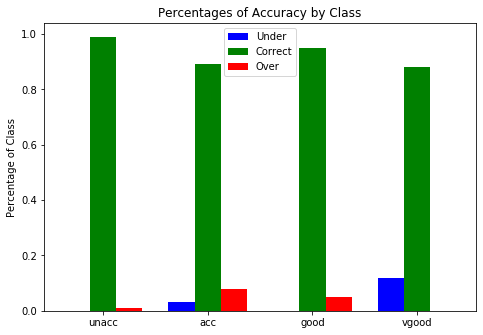

In [81]:
CM_prob = [[i/sum(j) for i in j] for j in CM]
under_prob = [0,CM_prob[1][0],0,CM_prob[3][1]]
correct_prob = [CM_prob[0][0],CM_prob[1][1],CM_prob[2][2],CM_prob[3][3]]
over_prob = [CM_prob[0][1],CM_prob[1][2]+CM_prob[1][3],CM_prob[2][3],0]

X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, under_prob, color = 'b', width = 0.25)
ax.bar(X + 0.25, correct_prob, color = 'g', width = 0.25,tick_label=["unacc","acc","good","vgood"])
ax.bar(X + 0.50, over_prob, color = 'r', width = 0.25)
ax.legend(labels=['Under', 'Correct','Over'])


ax.set_ylabel('Percentage of Class')

ax.set_title('Percentages of Accuracy by Class')


plt.show()

These bars present the normalized probabiltiees for each class, so even though the model tends to overpredict, you can see that if the correct class of the car is 4, the model has a much higher tendency to underrate it than for any other class.

<h2>Conclusion </h2>
This model appears to be a very strong predicitor  of a car's value. IF I was to refine the model, I would spend a little time making sure that the "very good" value cars are not undervalued because the visualization shown above seems to show that this si the largest fault of the model.

The random forest approach is straightforward, and seems very appropriate for this data set due to the discrete datatypes and relatively low number of datapoints. 